![]()

# Stuff - uses the filter class

Kevin J. Walchko, Phd

24 Jan 2021

---

## Bosch BNO055

![](https://cdn-shop.adafruit.com/640x480/4646-00.jpg)

I will use this as a reference to determine how well I am doing. You can get a qwiic version from [Adafruit](https://www.adafruit.com/product/4646)

| Sensor         | Range            | Bits | Hz  |
|:---------------|------------------|------|-----|
| Accelerometer  | $\pm$4 g         | 14   | 100 |
| Gyroscopes     | $\pm$2000 dps    | 16   | 100 |
| Magnetic (x-y) | $\pm$1300 $\mu$T | -    | 20  |
| Magnetic (z)   | $\pm$2500 $\mu$T | -    | 20  |
| Temperature    | -40$^\circ$ to +85$^\circ$ | -    | 1   |

In [1]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import norm
from slurm.rate import Rate

from squaternion import Quaternion

import pandas as pd

from math import sqrt, atan2, asin, pi
from math import radians as deg2rad
from math import degrees as rad2deg

from filters.imufilter import IMUFilter
from filters.madgwick import MARG

from opencv_camera import Compressor

In [2]:
def loadPickle(filename):
    with open(filename, 'rb') as fd:
        d = pickle.load(fd)
    return d

def getData(filename):
    imu = {
        "accel": [],
        "gyro": [],
        "mag": [],
        "pres": [],
        "temp": [],
        "stamp": []
    }
    
    bno = {
        "euler": {
            "roll": [],
            "pitch": [],
            "yaw": [],
            "time": []
        },
        "q": {
            "w": [],
            "x": [],
            "y": [],
            "z": [],
            "time": []
        }
    }
    
    imgs = []
    comp = Compressor()
    
    stamp = []
    
    data = loadPickle(filename)
    tstart = data[0][-1] # last value is always time
    
    for d in data:
        try:
            a,g,m,p,t,q,e,dt = d
            imu["accel"].append(a)
            imu["gyro"].append(g)
            imu["mag"].append(m)
            imu["pres"].append(p)
            imu["temp"].append(t)
            imu["stamp"].append(dt - tstart)

            bno["q"]["w"].append(q[0])
            bno["q"]["x"].append(q[1])
            bno["q"]["y"].append(q[2])
            bno["q"]["z"].append(q[3])
            bno["q"]["time"].append(dt - tstart)
            bno["euler"]["roll"].append(e[0])
            bno["euler"]["pitch"].append(e[1])
            bno["euler"]["yaw"].append(e[2])
            bno["euler"]["time"].append(dt - tstart)

            stamp.append(dt - tstart)
        except ValueError:
            a,g,m,p,t,q,e,(b, shape), dt = d
            imu["accel"].append(a)
            imu["gyro"].append(g)
            imu["mag"].append(m)
            imu["pres"].append(p)
            imu["temp"].append(t)
            imu["stamp"].append(dt - tstart)

            bno["q"]["w"].append(q[0])
            bno["q"]["x"].append(q[1])
            bno["q"]["y"].append(q[2])
            bno["q"]["z"].append(q[3])
            bno["q"]["time"].append(dt - tstart)
            bno["euler"]["roll"].append(e[0])
            bno["euler"]["pitch"].append(e[1])
            bno["euler"]["yaw"].append(e[2])
            bno["euler"]["time"].append(dt - tstart)
            
            im = comp.uncompress(b, shape)
            imgs.append(im)

            stamp.append(dt - tstart)
            
    return imgs, imu, bno, stamp

>> imges: 178  imu: 894


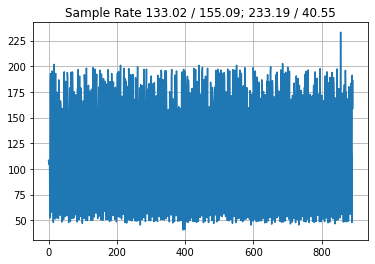

In [4]:
# fname = "../../software/python/data.pickle"
# fname = "../../software/python/dd.pickle"
# fname = "../../software/python/simple.pickle"
fname = "../../software/camera-imu/save/test2.pickle"

imgs, imu, bno, stamp = getData(fname)

print(f">> imges: {len(imgs)}  imu: {len(imu['accel'])}")

accel = np.array(imu["accel"])
gyro = np.array(imu["gyro"])
    
last = stamp[0]
hz = []
for t in stamp[1:]:
    hz.append(1.0/(t-last))
    last = t

# plt.plot(stamp[1:],hz)
plt.plot(hz)
plt.grid()
plt.title(f"Sample Rate {np.mean(hz):0.2f} / {np.median(hz):0.2f}; {max(hz):0.2f} / {min(hz):0.2f}");

# IMU Filter

In [5]:
# going to create a new DataFrame from Euler angles
e = {"roll":[], "pitch":[],"yaw":[],"time":[]}
qq = {"w":[], "x":[],"y":[], "z":[],"time":[]}

start = stamp[0]
last = stamp[0]-0.1 # starting time stamp
tt = 0               # Test time
B = sqrt(3/4)*1*pi/180  # gyro measurement error rad/s
filt = IMUFilter(B)
filt.wcomp = False
filt.wdr = 0.9
wes = []

for a, g, ts in zip(accel, gyro, stamp):
    dt = ts - last # calculate time step
    
    q = filt.update(a,g,dt)  # get orientation
    qq["w"].append(q[0])
    qq["x"].append(q[1])
    qq["y"].append(q[2])
    qq["z"].append(q[3])
    qq["time"].append(ts-start) # keep track of test time
    
    wes.append(filt.wb) # save gyro bias est for plotting
    r,p,y = q.to_euler(degrees=True)  # convert to euler
    e["roll"].append(r)
    e["pitch"].append(p)
    e["yaw"].append(y)
    e["time"].append(ts-start) # keep track of test time
    last = ts  # save previous time stamp

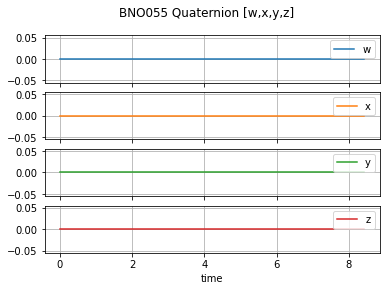

In [6]:
bnoq = pd.DataFrame(bno["q"])
bnoq.plot(
    x="time",
    subplots=True, grid=True, 
    title="BNO055 Quaternion [w,x,y,z]"
);

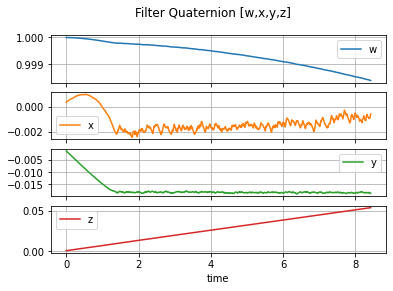

In [7]:
quat = pd.DataFrame(qq)
quat.plot(
    x="time", 
    subplots=True, grid=True, 
    title="Filter Quaternion [w,x,y,z]"
);

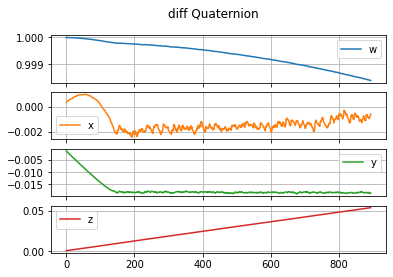

In [8]:
m = quat.iloc[:,:4] - bnoq.iloc[:,:4]
m.plot(
    subplots=True, grid=True, 
    title="diff Quaternion"
);

# MARG

In [9]:
# going to create a new DataFrame from Euler angles
e = {"roll":[], "pitch":[],"yaw":[],"time":[]}
mq = {"w":[], "x":[], "y":[],"z":[],"time":[]}

start = stamp[0]
last = stamp[0]-0.1 # starting time stamp
tt = 0               # Test time

Z = sqrt(3/4)*0.0
B = sqrt(3/4)*0.01 # gyro measurement error rad/s
filt = MARG(B, Z)
filt.wcomp = True
filt.bias = np.array([-19.472,  33.003,  -1.579])
filt.M = np.array(
    [[0.987, 0.,    0.,   ],
     [0.,    0.964, 0.,   ],
     [0.,    0.,    1.,   ]]
)
wes = []

rad2deg = 180.0/np.pi

accel = np.array(imu["accel"])
gyro = np.array(imu["gyro"])
mag = np.array(imu["mag"])

for a, g, m, ts in zip(accel, gyro, mag, stamp):
    dt = ts - last # calculate time step
    
    q = filt.update(a,g,m,dt)  # get orientation
    mq["w"].append(q.w)
    mq["x"].append(q.x)
    mq["y"].append(q.y)
    mq["z"].append(q.z)
    mq["time"].append(ts-start)
    
    wes.append(filt.wb) # save gyro bias est for plotting
    r,p,y = q.to_euler(degrees=True)  # convert to euler
#     r,p,y = euler(q) # madgwick's appears wrong!
    e["roll"].append(r)
    e["pitch"].append(p)
    e["yaw"].append(y)
    
    e["time"].append(ts-start) # keep track of test time
    last = ts  # save previous time stamp

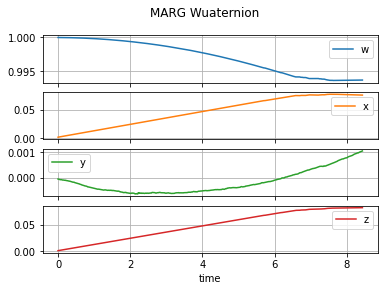

In [10]:
margq = pd.DataFrame(mq)
margq.plot(
    x="time", 
    subplots=True, 
    grid=True, 
    title="MARG Wuaternion"
);

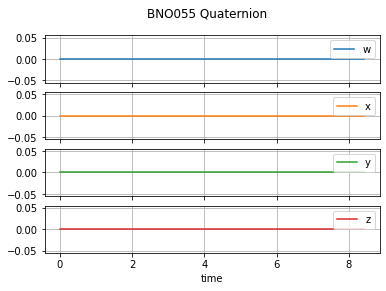

In [11]:
bnoquat = pd.DataFrame(bno["q"])
bnoquat.plot(
    x="time", 
    subplots=True, grid=True, 
    title="BNO055 Quaternion"
);

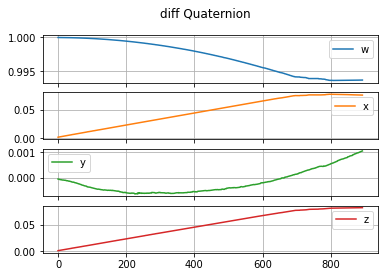

In [12]:
mm = margq.iloc[:,:4] - bnoquat.iloc[:,:4]
mm.plot(
    subplots=True, grid=True, 
    title="diff Quaternion"
);

# Camera

In [13]:
from ipywidgets import Video

Video.from_file("test.mp4", autoplay=False, loop=False, width=300, controls=True)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\xc2i\x17mdat\x00\x…

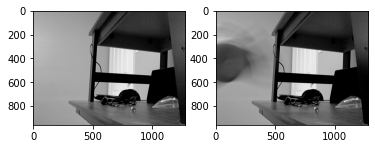

In [14]:
plt.subplot(121)
plt.imshow(imgs[0], cmap="gray")
plt.subplot(122)
plt.imshow(imgs[-1], cmap="gray");

In [15]:
from opencv_camera import SaveVideo

In [16]:
# mpeg = SaveVideo()
# mpeg.write_list(imgs, fname='test.mp4', fps=20)